In [220]:
import seaborn as sns
sns.set_style("whitegrid")
from process_model import *
from scipy.stats import norm

from chase.base import *
from chase.utils import *
from chase.fit import *

from cogmod import cpt as cptmodel


import pickle

PARS = {'theta': [1, 20],
        'c': [.01, 2, .5],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],}

FIGDEST = '/Users/markant/Dropbox/Apps/ShareLaTeX/ssDFE/ssDFE_v3/figures/'

def generate_normal_problem(problem_pars, n_x=50):
    prob = []
    for m, s in problem_pars:
        
        outcomes = norm.rvs(m, s, n_x)
        p = norm.pdf(outcomes)
        p = np.array([np.max([.01, p_i]) for p_i in p])
        p = p/p.sum()

        prob.append(np.transpose((outcomes, p)))
    problem = np.array(prob)
    return problem

def expected_value(opt):
    return np.dot(opt[:,0], opt[:,1])

# Binary gambles

In [2]:
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}

# Recovery

In [424]:
def fit_chase(problems, data, fit_pars):
        
    FIXED = {'dt': .05,
             'minsamplesize': 2}
    N_ITER = 1
    SIM_ID = 'recover_process_data'
    OUTDIR = 'chase_fitresults_recover_process_data'

    fitting = {p: PARS[p] for p in fit_pars}

    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='indifferent',
                   problems=problems)

    # fit
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR, quiet=False)
    best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                               fitting = fitting, 
                               outdir=OUTDIR)

    return best, pred


PARS = {'theta': [2, 25],
        'c': [.01, 2, .5],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],}

fitting_cpt = {'s': [0, np.inf, 1.],
               'prelec_gamma': [0, 10, 1.],
               'prelec_elevation': [0, 5, 1.]}

def predicted_samplesize(pred):
    cp = pred['p_resp'][1]
    ss = pred['p_stop_cond'][:,1]*cp + pred['p_stop_cond'][:,0]*(1-cp)
    ss = ss/float(ss.sum())
    return np.array(ss)

def observed_samplesize(data):
    bc = np.bincount(data.samplesize)
    return bc/float(bc.sum())

def predicted_cp(pred):
    cp = pred['p_resp'][1]
    return cp

def observed_cp(data):
    return data.choice.mean()

In [3]:
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}

In [132]:
with open('/Users/markant/code/chase/chase/paper/glockner_exp3_problems.pkl', 'r') as f:
    glockner_exp3_problems = pickle.load(f)

problems = {}
for p in glockner_exp3_problems:
    if np.sum(glockner_exp3_problems[p][:,:,0].ravel() < 0)==0:
        if np.random.random() < .05:
            problems[p] = glockner_exp3_problems[p]

In [75]:
with open('/Users/markant/code/chase/chase/paper/data/tpt_problems.pkl', 'r') as f:
    problems = pickle.load(f)

## Single problem, normally distributed outcomes

In [381]:
problems = {i: generate_normal_problem([[np.random.random()*4, 10.], 
                                        [np.random.random()*4, 10.]], n_x=200) for i in range(10)}

In [378]:
N = 1000

gen_pars = []
for gamma in [1.]:
    for theta in [1, 3]:
        for p_stay in [0.]:
        
            gen_pars.append({'N': N,
                             'theta': theta,
                             'p_stay': p_stay,
                             'prelec_gamma': gamma})

In [382]:
cols = ['theta', 'p_stay', 'gamma', 'subject', 'problem', 'problem-subject', 'group', 'choice', 'samplesize']
df = pd.DataFrame(columns=cols)

for gp in gen_pars:

    samplesize, choices, problems_exp = simulate_process(problems, gp, relfreq=True)
    print np.round([choices[pid].mean() for pid in problems], 3)

    data = []
    for pid in problems:
        arr = np.transpose(([gp['theta'] for _ in range(N)], 
                            [gp['p_stay'] for _ in range(N)],
                            [gp['prelec_gamma'] for _ in range(N)],
                            range(N), 
                            [pid for _ in range(N)], 
                            [('%s-%s' % (pid, i)) for i in range(N)],
                            np.zeros(N, int), 
                            np.array(choices[pid], int), np.array(samplesize[pid], int)))
        data.append(arr)
    data = pd.DataFrame(np.concatenate(data, axis=0), columns=cols)
    df = pd.concat((df, data))

df = df.convert_objects(convert_numeric=True)      

#problems_exp_by_subj = {}
#for i in range(N):
#    for pid in problems:
#        problems_exp_by_subj['%s-%s' % (pid, i)] = problems_exp[pid][i]

[ 0.608  0.503  0.439  0.583  0.381  0.478  0.454  0.495  0.605  0.459]
[ 0.737  0.482  0.37   0.633  0.232  0.452  0.416  0.515  0.643  0.412]


In [21]:
cpt_fits_obj = {}
cpt_fits_exp = {}
chase_fits = {}
N_FIT_ITER = 1

In [383]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    cpt_fits_obj[k] = cptmodel.fit(problems, 
                              data, 
                              'cptfit_1normal', 
                              fixed={}, fitting=fitting_cpt,
                              niter=N_FIT_ITER)
    print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'prelec_gamma', 'prelec_elevation'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

{'theta': 1, 'prelec_gamma': 1.0, 'p_stay': 0.0, 'N': 1000}
cptfit_1normal(prelec_elevation,prelec_gamma,s|)
[ 1.  1.  1.] 6970.70591809
[ 1.05  1.    1.  ] 6954.07776432
[ 1.    1.05  1.  ] 6942.7414581
[ 1.    1.    1.05] 6995.75871307
[ 1.03333333  1.03333333  0.95      ] 6922.26384042
[ 1.05  1.05  0.9 ] 6895.94845912
[ 1.06666667  1.06666667  0.93333333] 6897.50893303
[ 1.02777778  1.11111111  0.88888889] 6879.44045507
[ 1.01666667  1.16666667  0.83333333] 6858.9183447
[ 1.08888889  1.13888889  0.77777778] 6849.39300232
[ 1.13333333  1.18333333  0.66666667] 6838.00277362
[ 1.06666667  1.2         0.66666667] 6837.79721648
[ 1.06666667  1.26666667  0.53333333] 6839.53527312
[ 1.09444444  1.31666667  0.54444444] 6841.87601805
[ 1.17962963  1.3         0.41851852] 6853.66307907
[ 1.13888889  1.26666667  0.52222222] 6842.24742521
[ 1.05740741  1.2         0.72962963] 6841.548206
[ 1.07716049  1.07222222  0.8308642 ] 6868.72098529
[ 1.09012346  1.25555556  0.61604938] 6837.57155802
[ 1

KeyboardInterrupt: 

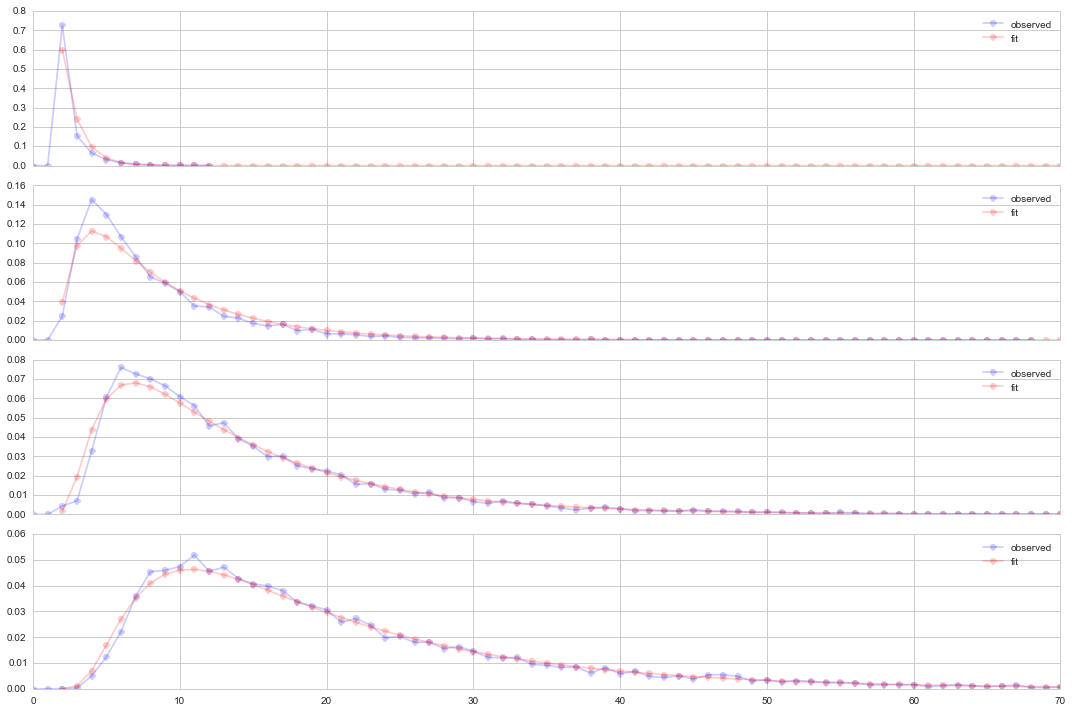

In [351]:
fig, axi = plt.subplots(len(gen_pars), 1, figsize=(15,10), sharex=True)

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    ax = axi[i]
    
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(ss, '-o', color='blue', alpha=.2, label='observed')
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(2, len(pred_ss)+2), pred_ss, '-o', color='red', alpha=.2, label='fit')
        ax.set_xlim(0, 70)
        ax.legend()
plt.tight_layout()
plt.show()

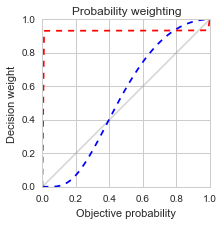

In [369]:
def prelec(p, prelec_elevation, prelec_gamma):
    return np.exp(-prelec_elevation * ((-np.log(p)) ** prelec_gamma))

p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(3,3))
axi.plot([0, 1], [0, 1], color='gray', alpha=.3)
#axi.plot(p, prelec(p, 1, .5), '--', color='black')
axi.plot(p, prelec(p, .07, .01), '--', color='red')
axi.plot(p, prelec(p, 1.07, 1.92), '--', color='blue')

axi.set_title('Probability weighting')
axi.set_xlabel('Objective probability')
axi.set_ylabel('Decision weight')
plt.show()

/Users/markant/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


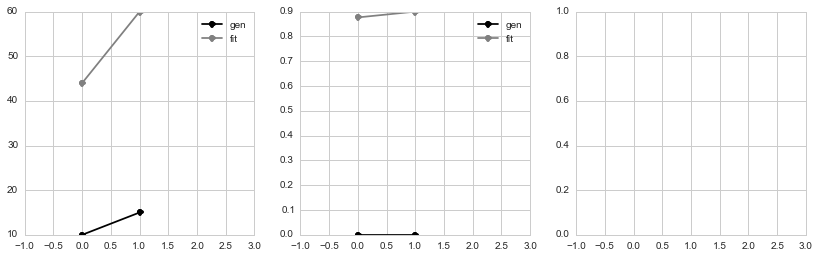

In [26]:
bf_par   = {'theta': [], 'p_stay': [], 'tau': []}
true_par = {'theta': [], 'p_stay': [], 'tau': []}

for gp in gen_pars:
    
    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    for par in ['theta', 'tau']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 3, figsize=(14,4))

for i, par in enumerate(['theta', 'tau']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()

## multiple problems, binary outcomes

In [400]:
problems = {}
i = -1
for p in [.01, .05, .1, .2, .4, .5, .6, .8, .9, .95, .99]:
    for _ in range(2):
        i += 1
        
        q = np.random.random()
        
        problems[i] = np.array([[[20 + np.random.random()*10, q],
                                 [0, 1-q]],
                                [[np.random.random()*100, p],
                                 [0, 1-p]]])
        
problemid = 'prange'

In [425]:
problems = {}
i = -1
for p in [.01, .05, .1, .2, .4, .5, .6, .8, .9, .95, .99]:
    i += 1
    problems[i] = np.array([[[1, 1],
                             [0, 0]],
                            [[2/p, p],
                             [0, 1-p]]])
        
for p in [.01, .05, .1, .2, .4, .5, .6, .8, .9, .95, .99]:
    i += 1
    problems[i] = np.array([[[2/p, p],
                             [0, 1-p]],
                            [[1, 1],
                             [0, 0]]])

problemid = 'prange'

In [421]:
problems = {}
i = -1
for p in [.01, .05, .1, .2, .5, .8, .9, .95, .99]:
    i += 1
    problems[i] = np.array([[[2, 1],
                             [0, 0]],
                            [[3, p],
                             [1, 1-p]]])
for p in [.01, .05, .1, .2, .5, .8, .9, .95, .99]:
    i += 1
    problems[i] = np.array([[[3, p],
                             [1, 1-p]],
                            [[2, 1],
                             [0, 0]]])

problemid = 'prange'

In [225]:
problemid = 'prange'

#pset = [.05, .1, .3, .5, .7, .9, .95]
pset = [.05, .1, .2, .4, .6, .9, .95]

problems = {}
i = -1
for p in pset:
    for v in [.5, 2, 10, 40, 100]:
        i += 1
        problems[i] = np.array([[[1, 1],
                                 [0, 0]],
                                [[v, p],
                                 [0, 1-p]]])
        
for p in pset:
    for v in [-5, -10]:
        i += 1
        problems[i] = np.array([[[1, 1],
                                 [0, 0]],
                                [[v, p],
                                 [0, 1-p]]])

In [273]:
int_high = np.array([50])

M = 100
problems_rare = []
for i in range(M):
    low = np.random.random() * 50
    highs = low + int_high + np.random.random(len(int_high)) * 100
    
    #r = np.random.random() * .3
    r = np.random.random()
    p = np.array([1 - r, r])
        
    R = [[low, p[0]]]
    for h, p_i in zip(highs, p[1:]):
        R.append([h, p_i])
    R = np.array(R)

    S = [[expected_value(R) - np.random.random() * 10, 1.]]
    for h in highs:
        S.append([0., 0.])
    S = np.array(S)
    
    problems_rare.append(np.array([S, R]))

problems = {}
for i, problem in enumerate(problems_rare):
    problems[i] = problem

In [269]:
# normally distributed
problems = {i: generate_normal_problem([[np.random.random()*1, 5], 
                                        [np.random.random()*1, 5]], n_x=5) for i in range(10)}

In [60]:
cpt_fits_obj = {}
cpt_fits_exp = {}
chase_fits = {}
N_FIT_ITER = 1

In [426]:
N = 500

gen_pars = []
for theta in [1, 3]:
    for gamma in [1]:
        for p_stay in [0.]:
        
            gen_pars.append({'N': N,
                             'theta': theta,
                             'p_stay': p_stay,
                             'prelec_gamma': gamma})
            
cols = ['theta', 'p_stay', 'gamma', 'subject', 'problem', 'problem-subject', 'group', 'choice', 'samplesize']
df = pd.DataFrame(columns=cols)

for gp in gen_pars:

    samplesize, choices, problems_exp = simulate_process(problems, gp, relfreq=True)
    print np.round([choices[pid].mean() for pid in problems], 3)

    data = []
    for pid in problems:
        arr = np.transpose(([gp['theta'] for _ in range(N)], 
                            [gp['p_stay'] for _ in range(N)],
                            [gp['prelec_gamma'] for _ in range(N)],
                            range(N), 
                            [pid for _ in range(N)], 
                            [('%s-%s' % (pid, i)) for i in range(N)],
                            np.zeros(N, int), 
                            np.array(choices[pid], int), np.array(samplesize[pid], int)))
        data.append(arr)
    data = pd.DataFrame(np.concatenate(data, axis=0), columns=cols)
    df = pd.concat((df, data))

df = df.convert_objects(convert_numeric=True)      

#problems_exp_by_subj = {}
#for i in range(N):
#    for pid in problems:
#        problems_exp_by_subj['%s-%s' % (pid, i)] = problems_exp[pid][i]

[ 0.186  0.36   0.518  0.55   0.682  0.624  0.766  0.38   0.446  0.482
  0.484  0.848  0.654  0.526  0.498  0.262  0.326  0.238  0.592  0.566
  0.544  0.494]
[ 0.462  0.678  0.796  0.82   0.888  0.892  0.848  0.832  0.932  0.894
  0.466  0.562  0.284  0.254  0.162  0.094  0.122  0.118  0.132  0.072
  0.102  0.504]


In [429]:
PARS = {'theta': [2, 20],
        'c': [.01, 2, .5],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],}

fitting_cpt = {'s': [0, np.inf, 1.],
               'prelec_gamma': [0, 10, 1.]}
               #'prelec_elevation': [0, 5, 1.]}


for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    if True:
        cpt_fits_obj[k] = cptmodel.fit(problems, 
                                  data, 
                                  'cptfit_%s' % problemid, 
                                  fixed={}, fitting=fitting_cpt,
                                  niter=N_FIT_ITER)
        print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_%s_exp' % problemid, 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'c', 'prelec_gamma'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

{'theta': 1, 'prelec_gamma': 1, 'p_stay': 0.0, 'N': 500}
cptfit_prange(prelec_gamma,s|)
[ 1.  1.] 8980.8785627
[ 1.05  1.  ] 8578.07059811
[ 1.    1.05] 9112.39327579
[ 1.05  0.95] 8483.40735777
[ 1.075  0.9  ] 8263.46967782
[ 1.125  0.9  ] 8065.77077494
[ 1.1875  0.85  ] 7860.25364445
[ 1.2125  0.75  ] 7746.96414432
[ 1.29375  0.625  ] 7618.73186036
[ 1.40625  0.575  ] 7576.13116318
[ 1.571875  0.4125  ] 7554.81776595
[ 1.678125  0.1875  ] 7571.41647584
[ 1.459375  0.4625  ] 7553.28431384
[ 1.353125  0.6875  ] 7621.62563329
[ 1.596875  0.3125  ] 7554.10503736
[ 1.484375  0.3625  ] 7547.20732268
[ 1.440625  0.3375  ] 7547.00346068
[ 1.303125  0.4875  ] 7575.55667574
[ 1.5234375  0.35625  ] 7548.76274138
[ 1.5046875  0.23125  ] 7557.06451172
[ 1.47070312  0.4046875 ] 7548.22534942
[ 1.38789062  0.3859375 ] 7549.28879209
[ 1.48955078  0.36367187] 7547.37184838
[ 1.45947266  0.29648437] 7549.01505138
[ 1.46789551  0.37763672] 7547.07910829
[ 1.41896973  0.35146484] 7547.18952717
[ 1.43661

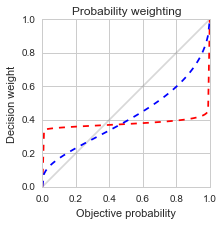

In [411]:
def prelec(p, prelec_elevation, prelec_gamma):
    return np.exp(-prelec_elevation * ((-np.log(p)) ** prelec_gamma))

p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(3,3))
axi.plot([0, 1], [0, 1], color='gray', alpha=.3)
#axi.plot(p, prelec(p, 1, .5), '--', color='black')
axi.plot(p, prelec(p, 1, .05), '--', color='red')
axi.plot(p, prelec(p, 1.14, .53), '--', color='blue')

axi.set_title('Probability weighting')
axi.set_xlabel('Objective probability')
axi.set_ylabel('Decision weight')
plt.show()

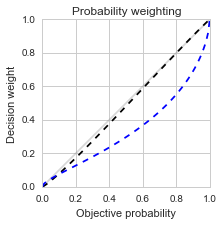

In [121]:
p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(3,3))
axi.plot([0, 1], [0, 1], color='gray', alpha=.3)
axi.plot(p, prelec(p, 1.07, 1.04), '--', color='black')
axi.plot(p, prelec(p, 1.53, .63), '--', color='blue')

axi.set_title('Probability weighting')
axi.set_xlabel('Objective probability')
axi.set_ylabel('Decision weight')
plt.show()

## multiple problems, normally distributed outcomes

In [101]:
problems = {i: generate_normal_problem([[1, 1.], [2, 1.]], n_x=3) for i in range(20)}

In [102]:
cpt_fits_obj = {}
cpt_fits_exp = {}
chase_fits = {}
N_FIT_ITER = 1

In [113]:
N = 1000

gen_pars = []
for theta in [5, 10]:
    for gamma in [.5, 1., 1.5]:
        for p_stay in [0.]:
        
            gen_pars.append({'N': N,
                             'theta': theta,
                             'p_stay': p_stay,
                             'prelec_gamma': gamma})
            
cols = ['theta', 'p_stay', 'gamma', 'subject', 'problem', 'problem-subject', 'group', 'choice', 'samplesize']
df = pd.DataFrame(columns=cols)

for gp in gen_pars:

    samplesize, choices, problems_exp = simulate_process(problems, gp, relfreq=True)
    print np.round([choices[pid].mean() for pid in problems], 3)

    data = []
    for pid in problems:
        arr = np.transpose(([gp['theta'] for _ in range(N)], 
                            [gp['p_stay'] for _ in range(N)],
                            [gp['prelec_gamma'] for _ in range(N)],
                            range(N), 
                            [pid for _ in range(N)], 
                            [('%s-%s' % (pid, i)) for i in range(N)],
                            np.zeros(N, int), 
                            np.array(choices[pid], int), np.array(samplesize[pid], int)))
        data.append(arr)
    data = pd.DataFrame(np.concatenate(data, axis=0), columns=cols)
    df = pd.concat((df, data))

df = df.convert_objects(convert_numeric=True)      

#problems_exp_by_subj = {}
#for i in range(N):
#    for pid in problems:
#        problems_exp_by_subj['%s-%s' % (pid, i)] = problems_exp[pid][i]

[ 0.919  0.779  0.272  0.875  0.865  0.78   0.961  0.315  1.     0.865
  0.053  0.564  0.29   0.437  0.774  0.657  0.451  0.915  0.883  0.969]
[ 0.89   0.767  0.242  0.946  0.945  0.81   0.97   0.266  1.     0.877
  0.071  0.644  0.307  0.476  0.69   0.613  0.47   0.912  0.978  0.963]
[ 0.834  0.712  0.297  0.936  0.906  0.836  0.95   0.234  1.     0.803
  0.092  0.656  0.321  0.489  0.681  0.599  0.479  0.874  0.996  0.972]
[ 0.995  0.694  0.191  0.976  0.96   0.896  0.996  0.184  1.     0.95
  0.079  0.51   0.373  0.406  0.871  0.711  0.515  0.994  0.938  0.997]
[ 0.971  0.88   0.13   0.997  0.997  0.945  1.     0.115  1.     0.969
  0.007  0.542  0.143  0.397  0.821  0.708  0.509  0.986  1.     0.998]
[ 0.955  0.811  0.108  0.993  0.98   0.942  0.998  0.1    1.     0.929
  0.017  0.551  0.158  0.433  0.795  0.673  0.433  0.961  1.     0.996]


In [ ]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'p_stay'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

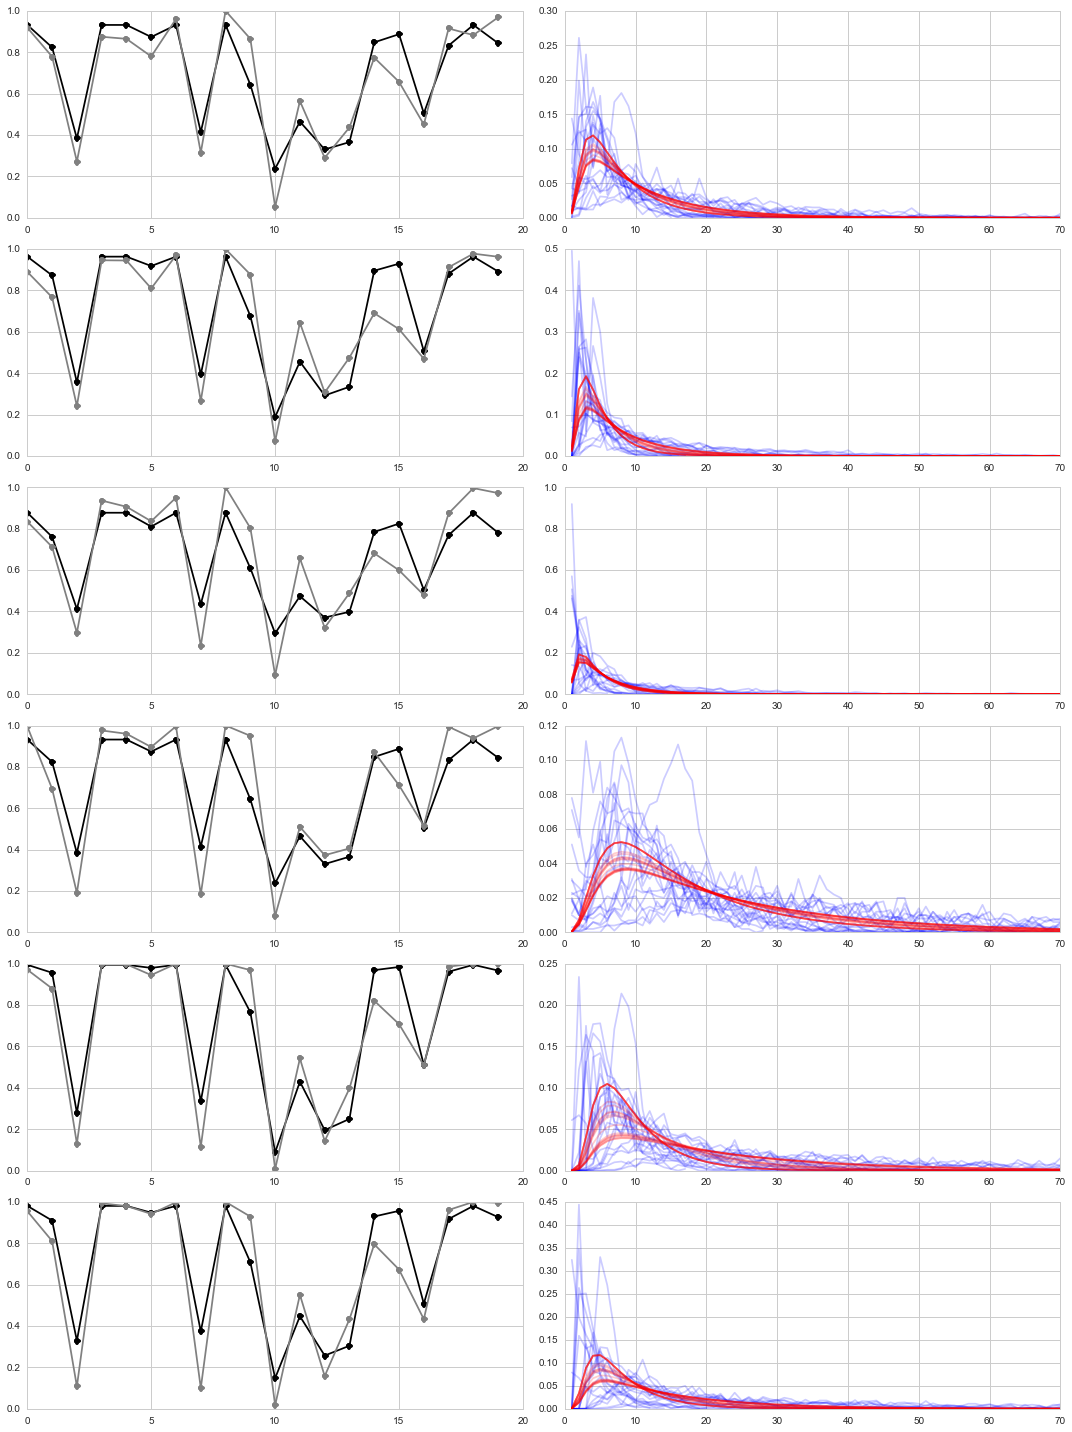

In [115]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], '-o', color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], '-o', color='gray')
    ax.set_ylim(0, 1)
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

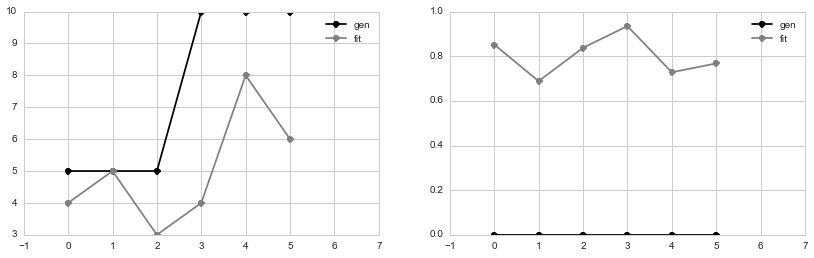

In [116]:
# recovered parameters
bf_par   = {'theta': [], 'p_stay': [], 'tau': []}
true_par = {'theta': [], 'p_stay': [], 'tau': []}

for gp in gen_pars:
    
    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    for par in ['theta', 'p_stay']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 2, figsize=(14,4))

for i, par in enumerate(['theta', 'p_stay']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()

## fit gamma

In [120]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'p_stay', 'prelec_gamma'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

{'theta': 5, 'prelec_gamma': 0.5, 'p_stay': 0.0, 'N': 1000}
recover_process_data(p_stay,prelec_gamma,theta|dt=0.1)
0/20
['theta']: [ 1.]
iteration               0
success              True
nllh              77629.4
k                       3
N                   20000
bic              155288.5
theta                   1
p_stay          0.9900812
prelec_gamma     1.763253
Name: 0, dtype: object
recover_process_data(p_stay,prelec_gamma,theta|dt=0.1)
1/20
['theta']: [ 2.]
iteration               0
success              True
nllh             75531.04
k                       3
N                   20000
bic              151091.8
theta                   2
p_stay          0.9612488
prelec_gamma     1.599158
Name: 1, dtype: object
recover_process_data(p_stay,prelec_gamma,theta|dt=0.1)
2/20
['theta']: [ 3.]
iteration               0
success              True
nllh             74802.75
k                       3
N                   20000
bic              149635.2
theta                   3
p_stay       

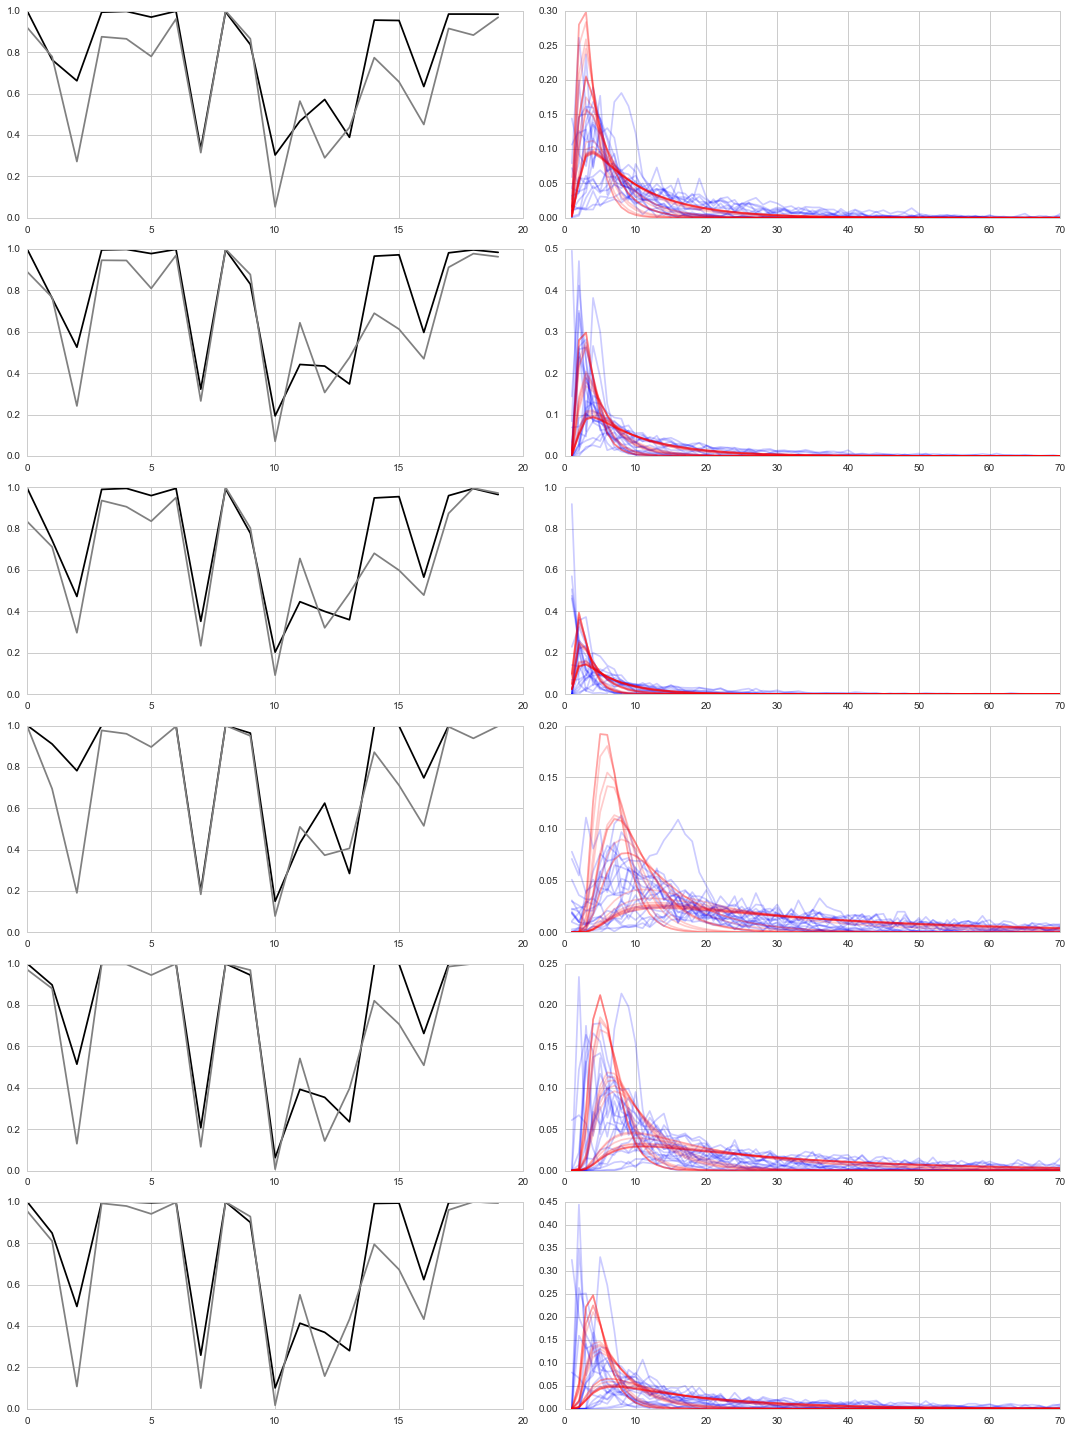

In [118]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], color='gray')
    ax.set_ylim(0,1)
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

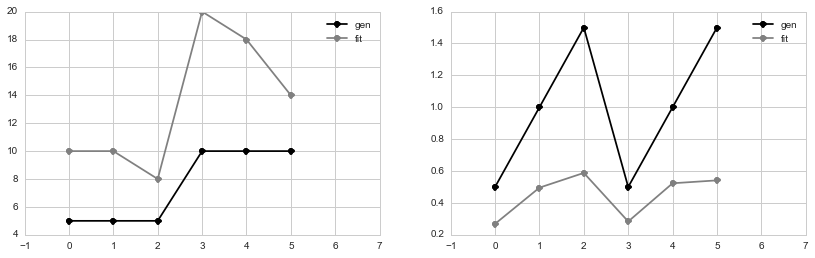

In [119]:
bf_par   = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}
true_par = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}

for gp in gen_pars:
    
    theta = gp['theta']
    #p_stay = gp['p_stay']
    p_stay = 0.
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    true_par['prelec_gamma'].append(gamma)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    #for par in ['theta', 'p_stay', 'tau', 'prelec_gamma']:
    for par in ['theta', 'prelec_gamma']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 2, figsize=(14,4))

#for i, par in enumerate(['theta', 'p_stay', 'tau', 'prelec_gamma']):
for i, par in enumerate(['theta', 'prelec_gamma']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()

## TPT

In [90]:
with open('/Users/markant/code/chase/chase/paper/data/tpt_problems.pkl', 'r') as f:
    problems = pickle.load(f)

In [91]:
cpt_fits_obj = {}
cpt_fits_exp = {}
chase_fits = {}
N_FIT_ITER = 1

In [92]:
N = 200  # N has to be low enough for sampling error to have an impact! 

gen_pars = []
for theta in [1, 2, 3, 4, 5]:
    for gamma in [.7, 1., 1.3]:
        for p_stay in [0.]:
        
            gen_pars.append({'N': N,
                             'theta': theta,
                             'p_stay': p_stay,
                             'prelec_gamma': gamma})
            
cols = ['theta', 'p_stay', 'gamma', 'subject', 'problem', 'problem-subject', 'group', 'choice', 'samplesize']
df = pd.DataFrame(columns=cols)

for gp in gen_pars:

    samplesize, choices, problems_exp = simulate_process(problems, gp, relfreq=True)
    print np.round([choices[pid].mean() for pid in problems], 3)

    data = []
    for pid in problems:
        arr = np.transpose(([gp['theta'] for _ in range(N)], 
                            [gp['p_stay'] for _ in range(N)],
                            [gp['prelec_gamma'] for _ in range(N)],
                            range(N), 
                            [pid for _ in range(N)], 
                            [('%s-%s' % (pid, i)) for i in range(N)],
                            np.zeros(N, int), 
                            np.array(choices[pid], int), np.array(samplesize[pid], int)))
        data.append(arr)
    data = pd.DataFrame(np.concatenate(data, axis=0), columns=cols)
    df = pd.concat((df, data))

df = df.convert_objects(convert_numeric=True)      



[ 0.41   0.46   0.46   0.505  0.49   0.47   0.63   0.51   0.485  0.31   0.56
  0.495  0.51   0.465  0.525  0.53   0.53   0.49   0.5    0.65   0.52
  0.545  0.575  0.485  0.47   0.565  0.455  0.585  0.485  0.66   0.55
  0.475  0.52   0.55   0.495  0.37   0.595  0.43   0.81   0.525  0.535
  0.495  0.48   0.52   0.545  0.49   0.505  0.465  0.64   0.525  0.455  0.7
  0.52   0.52   0.49   0.555  0.495  0.5    0.525  0.49 ]
[ 0.505  0.51   0.49   0.53   0.48   0.52   0.64   0.53   0.5    0.5    0.545
  0.51   0.515  0.48   0.475  0.465  0.515  0.5    0.51   0.61   0.595
  0.56   0.58   0.605  0.58   0.59   0.47   0.64   0.465  0.785  0.59
  0.465  0.52   0.555  0.595  0.44   0.61   0.44   0.75   0.51   0.5    0.545
  0.54   0.475  0.5    0.465  0.475  0.465  0.585  0.515  0.415  0.78
  0.515  0.52   0.54   0.54   0.405  0.47   0.5    0.53 ]
[ 0.545  0.505  0.485  0.48   0.48   0.56   0.595  0.53   0.52   0.54   0.47
  0.485  0.525  0.535  0.535  0.515  0.49   0.495  0.51   0.585  0.54   0.57

In [94]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'tau'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

{'theta': 1, 'prelec_gamma': 0.7, 'p_stay': 0.0, 'N': 200}
recover_process_data(tau,theta|)
0/10
['theta']: [ 1.]
iteration           0
success          True
nllh         77556.61
k                   2
N               12000
bic            155132
theta               1
tau               0.5
Name: 0, dtype: object
recover_process_data(tau,theta|)
1/10
['theta']: [ 2.]
iteration            0
success           True
nllh           25550.5
k                    2
N                12000
bic           51119.78
theta                2
tau          0.9999992
Name: 1, dtype: object
recover_process_data(tau,theta|)
2/10
['theta']: [ 3.]
iteration            0
success           True
nllh          30587.91
k                    2
N                12000
bic            61194.6
theta                3
tau          0.9999998
Name: 2, dtype: object
recover_process_data(tau,theta|)
3/10
['theta']: [ 4.]
iteration            0
success           True
nllh          34454.31
k                    2
N               

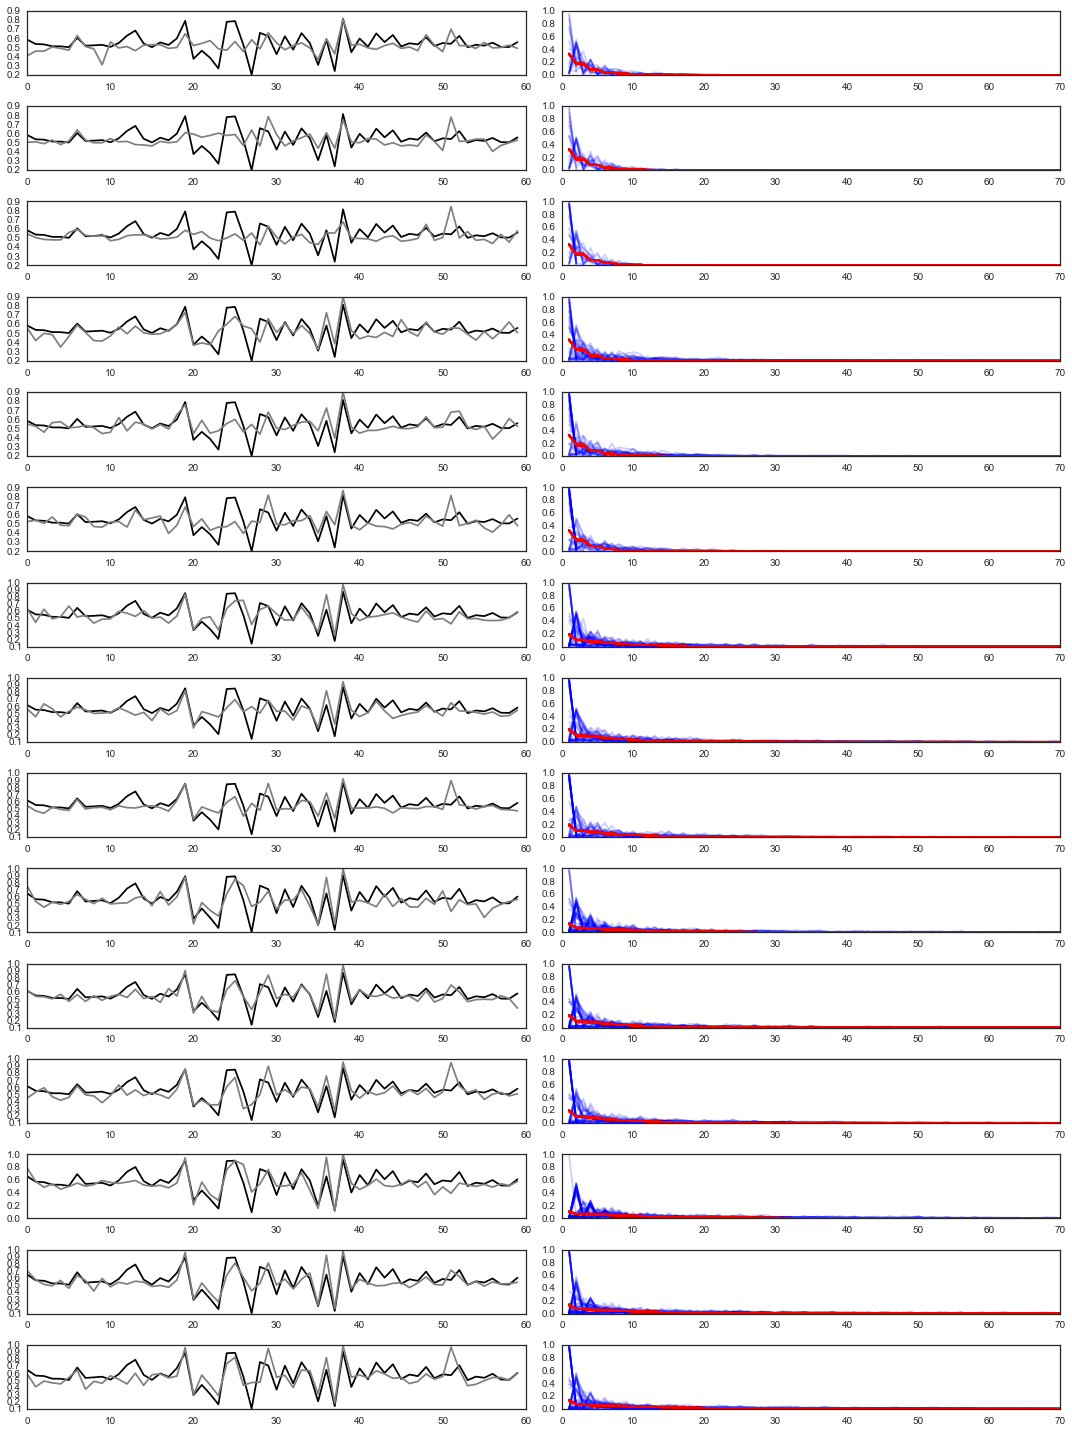

In [96]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], color='gray')
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

### fit gamma

In [97]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'prelec_gamma'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

{'theta': 1, 'prelec_gamma': 0.7, 'p_stay': 0.0, 'N': 200}
recover_process_data(prelec_gamma,theta|)
0/10
['theta']: [ 1.]
iteration               0
success              True
nllh             77556.02
k                       2
N                   12000
bic              155130.8
theta                   1
prelec_gamma    0.9689453
Name: 0, dtype: object
recover_process_data(prelec_gamma,theta|)
1/10
['theta']: [ 2.]
iteration              0
success             True
nllh            27418.38
k                      2
N                  12000
bic             54855.54
theta                  2
prelec_gamma     1.04375
Name: 1, dtype: object
recover_process_data(prelec_gamma,theta|)
2/10
['theta']: [ 3.]
iteration              0
success             True
nllh            36652.81
k                      2
N                  12000
bic              73324.4
theta                  3
prelec_gamma    1.066504
Name: 2, dtype: object
recover_process_data(prelec_gamma,theta|)
3/10
['theta']: [ 4.]
iteratio

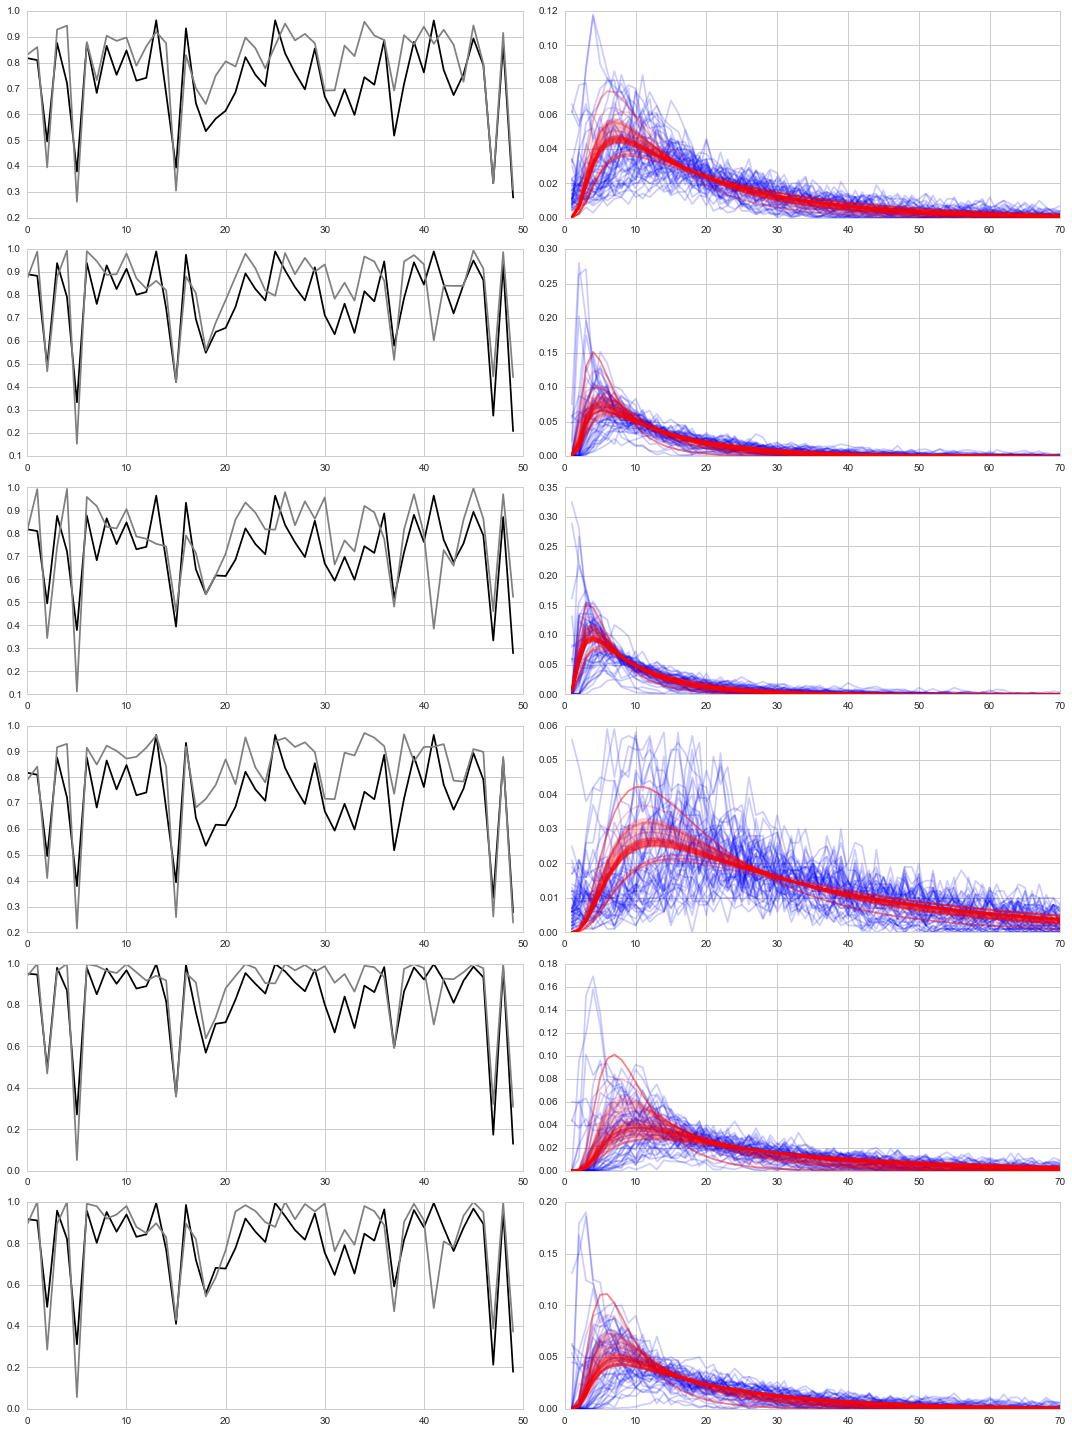

In [80]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], color='gray')
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

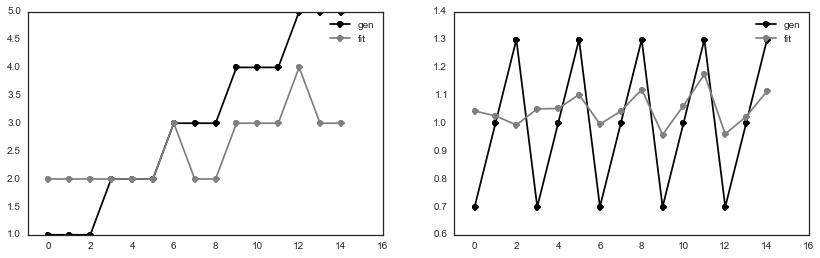

In [99]:
bf_par   = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}
true_par = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}

for gp in gen_pars:
    
    theta = gp['theta']
    #p_stay = gp['p_stay']
    p_stay = 0.
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    true_par['prelec_gamma'].append(gamma)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    #for par in ['theta', 'p_stay', 'tau', 'prelec_gamma']:
    for par in ['theta', 'prelec_gamma']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 2, figsize=(14,4))

#for i, par in enumerate(['theta', 'p_stay', 'tau', 'prelec_gamma']):
for i, par in enumerate(['theta', 'prelec_gamma']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()